In [13]:
import pandas as pd
import seaborn as sns
import pickle
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import econtools.metrics as mt
import numpy as np
from econtools import read, outreg, table_statrow, write_notes
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import statistics as s 
plt.style.use('seaborn-v0_8-deep')

In [30]:
original_df = pd.read_csv(
    r'C:\Users\faxul\Google Drive\RamirezRepStudy\thesisminusdata\TradeCode\paper_repstudy\notFeelingTheBuzz\Datafiles\clegg2_matches_cleaned.csv')
fitset = original_df[~(original_df['date'] > '2019-01-00')].copy()
testset = original_df[(original_df['date'] > '2019-01-00')].copy()

#testset = testset.dropna(subset=["inverse_b365", "inverse_best"])
#filtered_df = testset[testset['inverse_best'] > testset['inverse_b365']]
#testset.drop(filtered_df.index, inplace=True)

#testset.reset_index(inplace=True)
print('Fit set rows: ' + str(len(fitset)))
print('Test set rows: ' + str(len(testset)))

Fit set rows: 11513
Test set rows: 15693


In [31]:
def fit_regression(rankdist: bool = True, wikibuzz: bool = True):
    if wikibuzz and rankdist:
        results = mt.reg(fitset,'outcome',                      
        ['inverse_avg', 'rankdist', 'wikibuzz'],
        #fe_name= "year",
        cluster='match_id',addcons=True)
        params = [results.beta[-1], results.beta[0], results.beta[1], results.beta[2]]
        #params= [constant        , inverse_avg    , rankdist       , wikibuzz       ]
    elif wikibuzz and not rankdist:
        results = mt.reg(fitset,'outcome',
        ['inverse_avg', 'wikibuzz'],
        #fe_name= "year",
        cluster='match_id',addcons=True)
        params = [results.beta[-1], results.beta[0], results.beta[1]]
        #params= [constant        , inverse_avg    , wikibuzz       ]
    elif rankdist and not wikibuzz:
        results = mt.reg(fitset,'outcome',
        ['inverse_avg', 'rankdist'],
        #fe_name= "year",
        cluster='match_id',addcons=True)
        params = [results.beta[-1], results.beta[0], results.beta[1]]
        #params= [constant        , inverse_avg    , rankdist       ]
    elif not rankdist and not wikibuzz:
        results = mt.reg(fitset,'outcome',                      
        ['inverse_avg'],
        #fe_name= "year",
        cluster='match_id',addcons=True)
        params = [results.beta[-1], results.beta[0]]
        #params= [constant        , inverse_avg    ]
    print(results)
    return params

def simple_probability(params: pd.Series,
                         inverse_odds: float):
    y_hat = params[0] + params[1]*inverse_odds
    return y_hat

def estimate_probability(params: pd.Series,
                         inverse_odds: float,
                         rankdist: float = None,
                         wikibuzz: float = None) -> float:
    if rankdist and wikibuzz:
        y_hat = params[0] + params[-3]*inverse_odds + params[-2]*rankdist + params[-1]*wikibuzz
    if wikibuzz and not rankdist:
        y_hat = params[0] + params[-2]*inverse_odds + params[-1]*wikibuzz
    if rankdist and not wikibuzz:
        y_hat = params[0] + params[-2] * inverse_odds + params[-1] * rankdist
    if not rankdist and not wikibuzz:
        y_hat = params[0] + params[1]*inverse_odds
    return y_hat

def kelly_criterion(odds_implied_prob, y_hat):
    odds = 1/odds_implied_prob
    k = max(y_hat - ((1 - y_hat)/(odds - 1)), 0)
    return k

def profit_loss(kelly, odds_implied_prob, outcome):
    odds = 1 / odds_implied_prob
    if outcome == 1:
        PnL = kelly*odds - kelly
    if outcome == 0:
        PnL = -kelly
    return PnL

def show_results(testset, params, odds, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"

    # Estimate Probability.
    if rankdist and wikibuzz:
        testset['model_est_prob'] = [estimate_probability(params, row[0], row[1], row[2]) for row in zip(testset['inverse_avg'],
                                                                                                         testset['rankdist'],
                                                                                                         testset['wikibuzz'])]
    elif wikibuzz and not rankdist:
        testset['model_est_prob'] = [estimate_probability(params, inverse_odds=row[0], wikibuzz=row[1]) for row in zip(testset['inverse_avg'],
                                                                                                                       testset['wikibuzz'])]
    elif rankdist and not wikibuzz:
        testset['model_est_prob'] = [estimate_probability(params, inverse_odds=row[0], rankdist=row[1]) for row in zip(testset['inverse_avg'],
                                                                                                                       testset['rankdist'])]
    elif not rankdist and not wikibuzz:
        testset['model_est_prob'] = [simple_probability(params, inverse_odds=x) for x in testset['inverse_avg']]          
    # Determine kelly bet size.
    testset['kelly_betsize'] = [kelly_criterion(row[0], row[1]) for row in zip(testset['inverse_{}'.format(odds)],
                                                                               testset['model_est_prob'])]
    # Calculate return for the bet.
    testset['PnL'] = [profit_loss(row[0], row[1], row[2]) for row in zip(testset['kelly_betsize'],testset['inverse_{}'.format(odds)],
                                                                         testset['outcome'])]

    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print('Absolute amount bet: '+str(testset['kelly_betsize'].sum()))
    print('Absolute return: '+str(testset['PnL'].sum()))
    print('ROI (%): '+str((((testset['PnL'].sum() + testset['kelly_betsize'].sum())/testset['kelly_betsize'].sum())-1)*100))

def plot_results():
    testset['Cum_PnL'] = testset['PnL'].cumsum() * 100
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    testset.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5)
    
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    
    ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey').set_linewidth(2.5)
    
    plt.show()
    
def correct_kelly_results(odds, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"
    
    params = fit_regression(rankdist=rankdist,wikibuzz=wikibuzz)
    show_results(testset, params, odds, rankdist=rankdist, wikibuzz=wikibuzz)
    
    testset['bankroll_after'] = testset['PnL'] + 1
    testset['bankroll_after'] = testset['bankroll_after'].cumprod()
    testset['bankroll_before'] = testset.bankroll_after.shift(1)
    testset['betsize_of_inital_bankroll'] = testset['kelly_betsize'] * testset['bankroll_before']
    testset['pnl_of_initial_bankroll'] = testset['PnL'] * testset['bankroll_before']
    print("---------------")
    print("*Correct Kelly*")
    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print('Absolute amount bet: ' + str(testset['betsize_of_inital_bankroll'].sum()))
    print('Absolute return: ' + str(testset['pnl_of_initial_bankroll'].sum()))
    print('ROI (%): ' + str((((testset['pnl_of_initial_bankroll'].sum() + testset['betsize_of_inital_bankroll'].sum()) / testset[
    'betsize_of_inital_bankroll'].sum()) - 1)*100))
    
    
def correct_kelly_plot_results():
    testset["Cum_PnL"] = (testset["bankroll_after"] -1) * 100
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    testset.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5)
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey').set_linewidth(2.5)
    
    plt.show()

Dependent variable:	outcome
N:			11503
R-squared:		0.1590
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  5753
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.019 0.030 33.586 0.000  0.960   1.078
rankdist     0.051 0.036  1.420 0.156 -0.019   0.122
wikibuzz    -0.000 0.000 -1.335 0.182 -0.000   0.000
_cons       -0.038 0.016 -2.351 0.019 -0.069  -0.006

Bets considered (2 * Matches): 15577
Number of bets placed: 415
Mean overround (%): 5.893271577100623
Absolute amount bet: 10.128294007972455
Absolute return: 0.06706214054945839
ROI (%): 0.6621267164704125


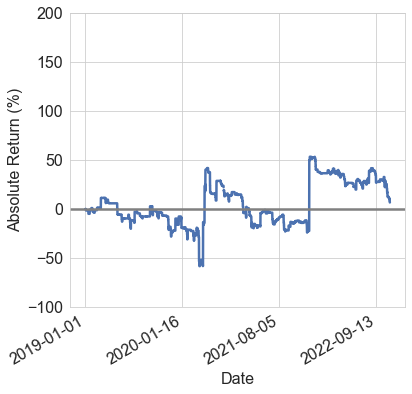

In [35]:
params = fit_regression(rankdist=True,wikibuzz=True)
show_results(testset, params=params, odds="b365", rankdist=True, wikibuzz=True)
plot_results()

In [27]:
params = fit_regression(rankdist=True)
show_results(testset, params=params, odds="best", rankdist=True)
# Set initial bankroll
initial_bankroll = 1000

# Calculate cumulative returns with changing bankroll
def calculate_cumulative_returns(data, initial_bankroll):
    data['cumulative_pnl'] = 0.0
    current_bankroll_wrong = initial_bankroll
    current_bankroll_proper = initial_bankroll
    
    for i, row in data.iterrows():
        frac_kelly = row['PnL'] * 0.5
        
        current_bankroll_wrong += frac_kelly * initial_bankroll
        data.at[i, 'cumulative_pnl_wrong'] = current_bankroll_wrong

        current_bankroll_proper += frac_kelly * current_bankroll_proper
        data.at[i, 'cumulative_pnl_proper'] = current_bankroll_proper

    return data

cumpnls_wrong = []
cumpnls_proper = []
strategy_stops_counter = 0

for i in range(0, 10000):
    
    testset_it = testset.sample(frac=0.75).reset_index(drop=True)
    # Call the function with your data
    result = calculate_cumulative_returns(testset_it, initial_bankroll)
    min_index = result["cumulative_pnl_wrong"].idxmin()
    if result.loc[min_index, 'cumulative_pnl_wrong'] < 0:
        cumpnls_wrong.append(0)
    elif (result.loc[min_index, 'cumulative_pnl_wrong'] > 0) & ((result.loc[min_index, 'kelly_betsize'] * 1000 ) > result.loc[min_index, 'cumulative_pnl_wrong']):
        cumpnls_wrong.append(result.loc[min_index, 'cumulative_pnl_wrong'])
        strategy_stops_counter += 1
    else:
        cumpnls_wrong.append(result["cumulative_pnl_wrong"].iloc[-1])

    cumpnls_proper.append(result["cumulative_pnl_proper"].iloc[-1])
    

Dependent variable:	outcome
N:			10816
R-squared:		0.1595
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  5408
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.043 0.033 31.283 0.000  0.977   1.108
rankdist     0.068 0.041  1.675 0.094 -0.012   0.147
wikibuzz     0.008 0.005  1.530 0.126 -0.002   0.018
_cons       -0.050 0.018 -2.847 0.004 -0.085  -0.016

Bets considered (2 * Matches): 13885
Number of bets placed: 7148
Mean overround (%): -0.5122072416349877
Absolute return: 8.841301701307243
Absolute amount bet: 274.80352210138
ROI (%): 3.2173174614718247


In [29]:
# Saving the lists to a file using pickle
# with open('half_kelly_lists.pickle', 'wb') as file:
#     pickle.dump(cumpnls_wrong, file)
#     pickle.dump(cumpnls_proper, file)

#Loading the lists from the file using pickle
with open('half_kelly_lists.pickle', 'rb') as file:
    cumpnls_wrong = pickle.load(file)
    cumpnls_proper = pickle.load(file)
    
cumpnls_wrong_returns = [((x- 1000)) for x in cumpnls_wrong]
cumpnls_proper_returns = [((x- 1000)) for x in cumpnls_proper]

In [24]:
count = sum(1 for x in cumpnls_proper_returns if x < -750)

print(count) # output: 1
print(strategy_stops_counter)

3110


NameError: name 'strategy_stops_counter' is not defined

In [33]:
proper_75loss = sum(1 for x in cumpnls_proper_returns if x < -750)
improper_75loss = sum(1 for x in cumpnls_wrong_returns if x < -750)
proper_bustrate = sum(1 for x in cumpnls_proper_returns if x == -1000)
improper_bustrate = sum(1 for x in cumpnls_wrong_returns if x == -1000)

print("Proper Bust Rate: "+str(proper_bustrate))
print("Proper >75% Loss Rate: "+str(proper_75loss))
print("Proper Kelly Mean Returns: "+str(s.mean(cumpnls_proper_returns)/1000))
print("Proper Standard Deviation: "+str(np.std(cumpnls_proper_returns)/1000))
print("Proper Sharpe Ratio: "+str((s.mean(cumpnls_proper_returns) / np.std(cumpnls_proper_returns))))
print("-----")
print("Improper Bust Rate: "+str(improper_bustrate))
print("Improper >75% Loss Rate: "+str(improper_75loss))
print("Improper Kelly Mean Returns: "+str(s.mean(cumpnls_wrong_returns)/1000))
print("Improper Standard Deviation: "+str(np.std(cumpnls_wrong_returns)/1000))
print("Improper Sharpe Ratio: "+str((s.mean(cumpnls_wrong_returns) / np.std(cumpnls_wrong_returns))))
#strategystopscounter = 152

Proper Bust Rate: 0
Proper >75% Loss Rate: 15
Proper Kelly Mean Returns: 6.026838623887058
Proper Standard Deviation: 8.004707463929043
Proper Sharpe Ratio: 0.7529117898493239
-----
Improper Bust Rate: 969
Improper >75% Loss Rate: 1118
Improper Kelly Mean Returns: 2.889511025975152
Improper Standard Deviation: 1.6441616979058615
Improper Sharpe Ratio: 1.7574372579384794
